In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip


In [3]:
import re
import json
import random
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata
import emoji

import nltk
import spacy
nlp = spacy.load("en_core_web_sm")

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('omw-1.4')

from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
 
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score,
    confusion_matrix, f1_score, precision_score, recall_score, hamming_loss,
    precision_recall_curve, roc_curve, auc
)
from wordcloud import WordCloud
from collections import Counter
from tqdm import tqdm
import time

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


In [5]:
!pip install contractions
import contractions


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.9/113.9 kB 8.3 MB/s eta 0:00:00


In [6]:
train = pd.read_csv("/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip")
test = pd.read_csv("/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip")

In [7]:
df = train.copy()
df_test = test.copy()

In [8]:
print(df.head())
print(df.shape)
print(df.dtypes)

                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  
(159571, 8)
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult   

In [9]:
missing_values = df.isnull().sum()
print((missing_values / len(df) * 100).round(2))
print("Duplicated rows: ",df.duplicated().sum())


id               0.0
comment_text     0.0
toxic            0.0
severe_toxic     0.0
obscene          0.0
threat           0.0
insult           0.0
identity_hate    0.0
dtype: float64
Duplicated rows:  0


In [10]:
label_cols = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

has_label_count = (df[label_cols].sum(axis=1)>0).sum()
print("Rows with labels:", has_label_count)

no_label_count = (df[label_cols].sum(axis=1) == 0).sum()
print("Rows with No Toxic Label:",no_label_count)


Rows with labels: 16225
Rows with No Toxic Label: 143346


toxic            15294
obscene           8449
insult            7877
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64


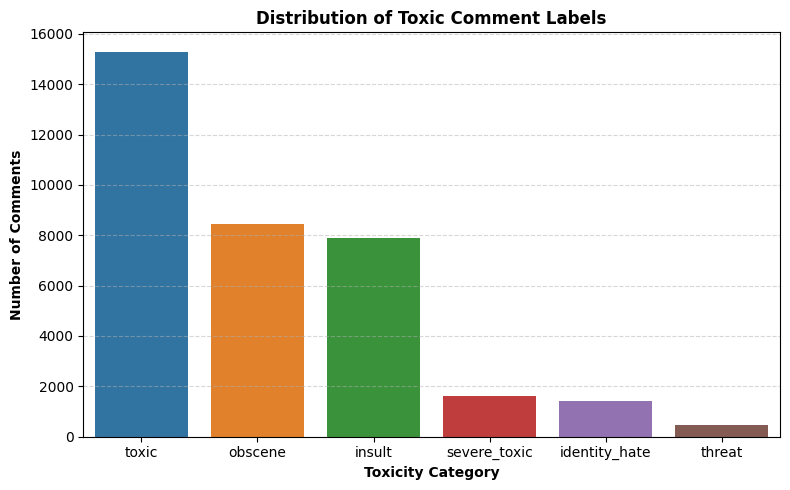

In [11]:


label_counts = df[label_cols].sum().sort_values(ascending=False)
print(label_counts)

plt.figure(figsize=(8,5))
sns.barplot(x=label_counts.index, y=label_counts.values)

# Add labels and title
plt.title("Distribution of Toxic Comment Labels", weight='bold')
plt.xlabel("Toxicity Category", weight='bold')
plt.ylabel("Number of Comments", weight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()

In [12]:

df['text_length'] = df['comment_text'].astype(str).apply(len)
df['word_count'] = df['comment_text'].astype(str).apply(lambda x: len(x.split()))

print(df[['text_length','word_count']].describe())

         text_length     word_count
count  159571.000000  159571.000000
mean      394.073221      67.273527
std       590.720282      99.230702
min         6.000000       1.000000
25%        96.000000      17.000000
50%       205.000000      36.000000
75%       435.000000      75.000000
max      5000.000000    1411.000000


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


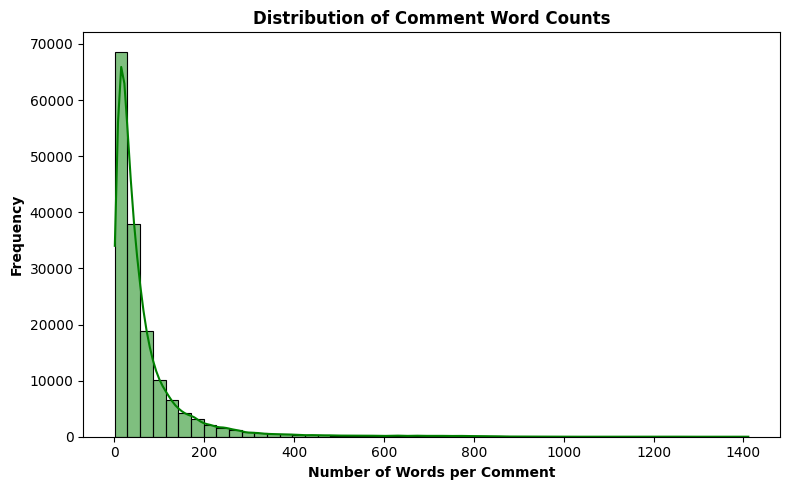

In [13]:
plt.figure(figsize=(8,5))
sns.histplot(df['word_count'], bins=50, color='green', kde=True)
plt.title("Distribution of Comment Word Counts",weight='bold')
plt.xlabel("Number of Words per Comment",weight='bold')
plt.ylabel("Frequency",weight='bold')
plt.tight_layout()

plt.show()

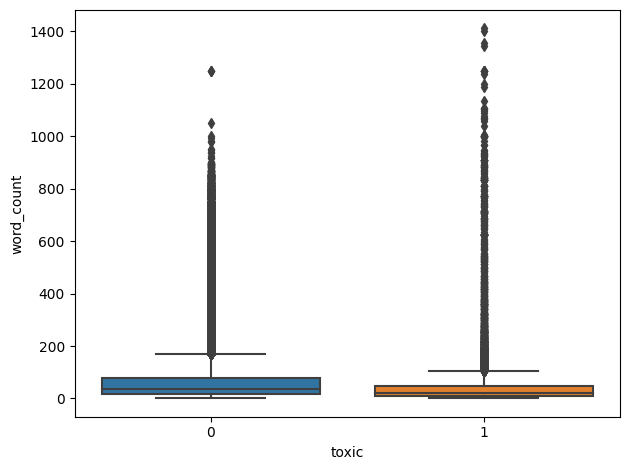

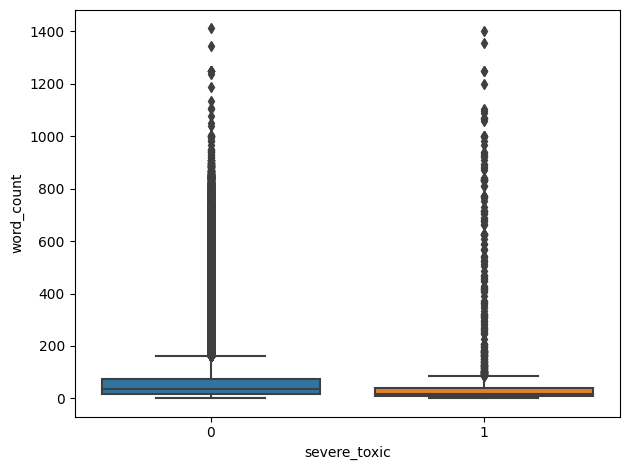

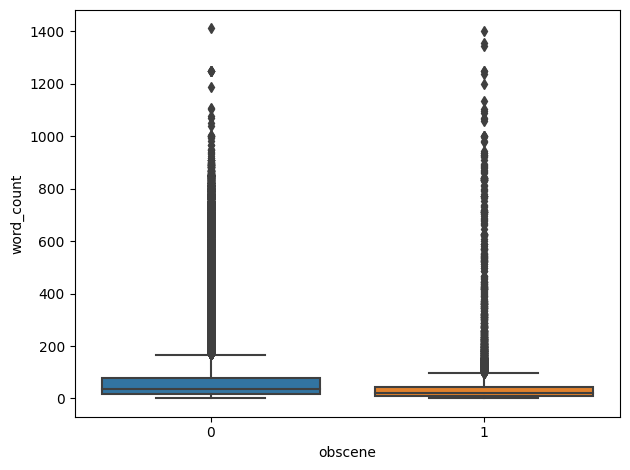

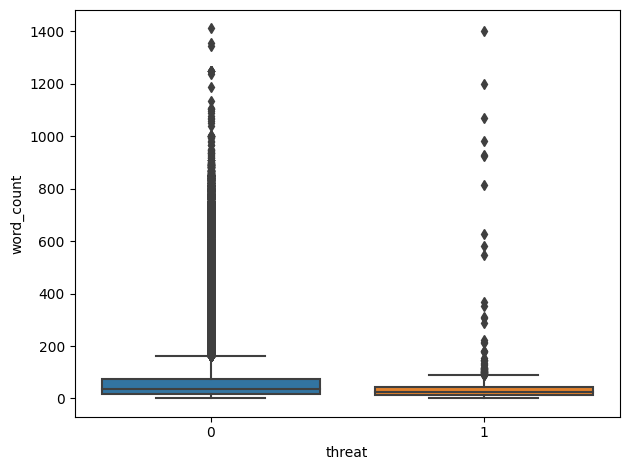

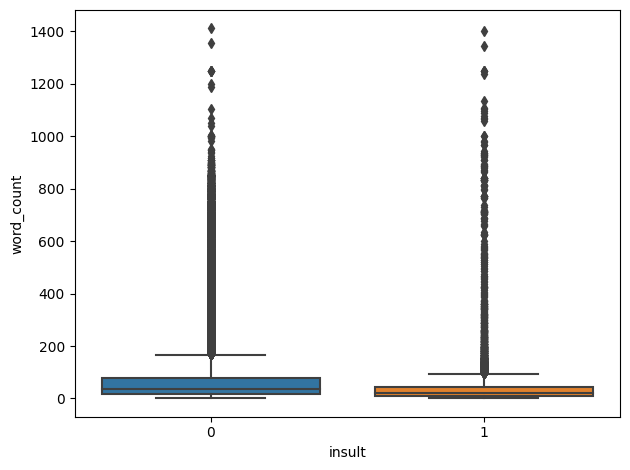

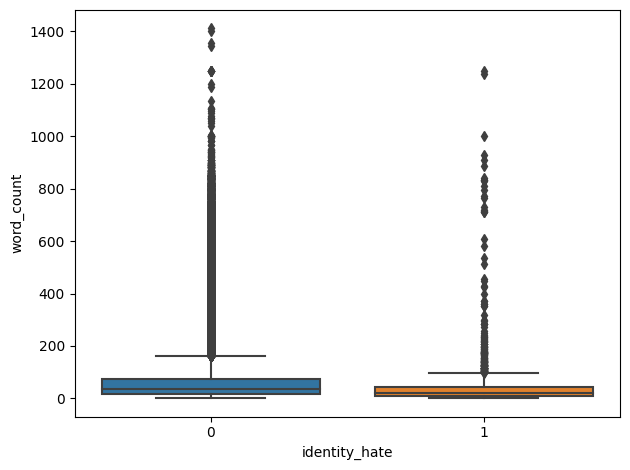

In [14]:
for x in label_cols:
    sns.boxplot(x=df[x], y=df['word_count'])
    plt.tight_layout()
    plt.show()

In [15]:
def contains_emoji(s):
    return any(char in emoji.EMOJI_DATA for char in str(s))

emoji_rows = df['comment_text'].apply(contains_emoji)
print(f"Comments containing emojis: {emoji_rows.sum()} / {len(df)} ({emoji_rows.mean()*100:.2f}%)")



Comments containing emojis: 1198 / 159571 (0.75%)


In [16]:
url_pattern = r'http\S+|www.\S+'
url_rows = df['comment_text'].str.contains(url_pattern, regex=True)
print(f"Comments containing URLs: {url_rows.sum()} / {len(df)} ({url_rows.mean()*100:.2f}%)")

Comments containing URLs: 5154 / 159571 (3.23%)


In [17]:
obfuscation_rows = df['comment_text'].str.contains(r'[@$0-9]', regex=True)
print(f"Comments with obfuscation-like symbols (0,1,@,$): {obfuscation_rows.sum()} / {len(df)} ({obfuscation_rows.mean()*100:.2f}%)")


Comments with obfuscation-like symbols (0,1,@,$): 51807 / 159571 (32.47%)


In [18]:
mention_rows = df['comment_text'].str.contains(r'@\w+', regex=True)
print(f"Comments with @mentions: {mention_rows.sum()} / {len(df)} ({mention_rows.mean()*100:.2f}%)")


Comments with @mentions: 718 / 159571 (0.45%)


In [19]:
hashtag_rows = df['comment_text'].str.contains(r'#\w+', regex=True)
print(f"Comments with hashtags: {hashtag_rows.sum()} / {len(df)} ({hashtag_rows.mean()*100:.2f}%)")


Comments with hashtags: 3156 / 159571 (1.98%)


In [20]:
non_ascii_rows = df['comment_text'].apply(lambda x: any(ord(c) > 127 for c in str(x)))
print(f"Comments with non-ASCII characters: {non_ascii_rows.sum()} / {len(df)} ({non_ascii_rows.mean()*100:.2f}%)")


Comments with non-ASCII characters: 17215 / 159571 (10.79%)


In [21]:
def clean_text(text):
    """
    Cleans and normalizes raw text for NLP preprocessing.
    Steps:
      1. Lowercasing
      2. Expand contractions
      3. Convert emojis to text
      4. Remove URLs, mentions, and hashtags (keep word)
      5. Normalize obfuscation
      6. Remove repeated characters (looooser → looser)
      7. Remove punctuation and non-ASCII characters
      8. Normalize whitespace
    """
    # Lowercasing
    text = str(text).lower()
    # Expand contractions
    text = contractions.fix(text)
    # Convert emojis to descriptive text
    text = emoji.demojize(text, delimiters=(" ", " "))
    # Remove URLs, mentions, and hashtags
    text = re.sub(r'http\S+|www.\S+', '', text)              # URLs
    text = re.sub(r'@\w+', '', text)                         # @mentions
    text = re.sub(r'#(\w+)', r'\1', text)                    # hashtags → keep the word
    # Normalize obfuscations
    text = re.sub(r'0', 'o', text)
    text = re.sub(r'1', 'i', text)
    text = re.sub(r'3', 'e', text)
    text = re.sub(r'4', 'a', text)
    text = re.sub(r'5', 's', text)
    text = re.sub(r'7', 't', text)
    text = re.sub(r'@', 'a', text)
    text = re.sub(r'\$', 's', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # keep only letters & spaces
    # Reduce repeated characters (e.g. loooove → loove)
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
    # Normalize unicode & remove non-ASCII characters
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [22]:

df['clean_text'] = df['comment_text'].apply(clean_text)

print("Before Cleaning:")
print(df['comment_text'].iloc[0])

print("\nAfter Cleaning:")
print(df['clean_text'].iloc[0])

Before Cleaning:
Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27

After Cleaning:
explanation why the edits made under my username hardcore metallica fan were reverted they were not vandalisms just closure on some gas after i voted at new york dolls fac and please do not remove the template from the talk page since i am retired nowoset


In [23]:
def tokenize_text(text):
    """Tokenizes text into individual words."""
    return nltk.word_tokenize(text)

df['tokenized'] = df['clean_text'].apply(tokenize_text)

print("Before tokenization:")
print(df['clean_text'].iloc[0])
print("\nAfter tokenization:")
print(df['tokenized'].iloc[0])

Before tokenization:
explanation why the edits made under my username hardcore metallica fan were reverted they were not vandalisms just closure on some gas after i voted at new york dolls fac and please do not remove the template from the talk page since i am retired nowoset

After tokenization:
['explanation', 'why', 'the', 'edits', 'made', 'under', 'my', 'username', 'hardcore', 'metallica', 'fan', 'were', 'reverted', 'they', 'were', 'not', 'vandalisms', 'just', 'closure', 'on', 'some', 'gas', 'after', 'i', 'voted', 'at', 'new', 'york', 'dolls', 'fac', 'and', 'please', 'do', 'not', 'remove', 'the', 'template', 'from', 'the', 'talk', 'page', 'since', 'i', 'am', 'retired', 'nowoset']


In [24]:

stop_words = set(stopwords.words('english'))

def remove_stopwords(tokens):
    """Removes common stopwords from tokenized text."""
    return [t for t in tokens if t.lower() not in stop_words and t.isalpha()]

df['no_stopwords'] = df['tokenized'].apply(remove_stopwords)

# Show before and after
print("Before stopword removal:")
print(df['tokenized'].iloc[0])
print("\nAfter stopword removal:")
print(df['no_stopwords'].iloc[0])


Before stopword removal:
['explanation', 'why', 'the', 'edits', 'made', 'under', 'my', 'username', 'hardcore', 'metallica', 'fan', 'were', 'reverted', 'they', 'were', 'not', 'vandalisms', 'just', 'closure', 'on', 'some', 'gas', 'after', 'i', 'voted', 'at', 'new', 'york', 'dolls', 'fac', 'and', 'please', 'do', 'not', 'remove', 'the', 'template', 'from', 'the', 'talk', 'page', 'since', 'i', 'am', 'retired', 'nowoset']

After stopword removal:
['explanation', 'edits', 'made', 'username', 'hardcore', 'metallica', 'fan', 'reverted', 'vandalisms', 'closure', 'gas', 'voted', 'new', 'york', 'dolls', 'fac', 'please', 'remove', 'template', 'talk', 'page', 'since', 'retired', 'nowoset']


In [25]:

lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    """Lemmatizes each token in the list."""
    return [lemmatizer.lemmatize(t) for t in tokens]

df['lemmatized'] = df['no_stopwords'].apply(lemmatize_tokens)

print("Before lemmatization:")
print(df['no_stopwords'].iloc[0])
print("\nAfter lemmatization:")
print(df['lemmatized'].iloc[0])


Before lemmatization:
['explanation', 'edits', 'made', 'username', 'hardcore', 'metallica', 'fan', 'reverted', 'vandalisms', 'closure', 'gas', 'voted', 'new', 'york', 'dolls', 'fac', 'please', 'remove', 'template', 'talk', 'page', 'since', 'retired', 'nowoset']

After lemmatization:
['explanation', 'edits', 'made', 'username', 'hardcore', 'metallica', 'fan', 'reverted', 'vandalism', 'closure', 'gas', 'voted', 'new', 'york', 'doll', 'fac', 'please', 'remove', 'template', 'talk', 'page', 'since', 'retired', 'nowoset']


In [26]:

def get_wordnet_pos(treebank_tag):
    """
    Converts NLTK POS tags (from pos_tag) to WordNet POS tags.
    Default is noun if tag not found.
    """
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


In [27]:

def lemmatize_with_pos(tokens):
    """
    Lemmatizes tokens using their POS tags for improved accuracy.
    """
    pos_tags = nltk.pos_tag(tokens)
    lemmatized = [
        lemmatizer.lemmatize(word, get_wordnet_pos(tag))
        for word, tag in pos_tags
    ]
    return lemmatized


In [28]:

tqdm.pandas()

df['pos_lemmatized'] = df['no_stopwords'].progress_apply(lemmatize_with_pos)

print("Before pos_lemmatization:")
print(df['no_stopwords'].iloc[0])
print("\nAfter pos_lemmatization:")
print(df['pos_lemmatized'].iloc[0])


100%|██████████| 159571/159571 [03:55<00:00, 678.72it/s]

Before pos_lemmatization:
['explanation', 'edits', 'made', 'username', 'hardcore', 'metallica', 'fan', 'reverted', 'vandalisms', 'closure', 'gas', 'voted', 'new', 'york', 'dolls', 'fac', 'please', 'remove', 'template', 'talk', 'page', 'since', 'retired', 'nowoset']

After pos_lemmatization:
['explanation', 'edits', 'make', 'username', 'hardcore', 'metallica', 'fan', 'revert', 'vandalisms', 'closure', 'gas', 'vote', 'new', 'york', 'doll', 'fac', 'please', 'remove', 'template', 'talk', 'page', 'since', 'retire', 'nowoset']


In [29]:

df['processed_text'] = df['pos_lemmatized'].apply(lambda tokens: " ".join(tokens))


In [30]:
print("Before preprocessing:")
print(df['comment_text'].iloc[0])
print("\nAfter preprocessing:")
print(df['processed_text'].iloc[0])

Before preprocessing:
Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27

After preprocessing:
explanation edits make username hardcore metallica fan revert vandalisms closure gas vote new york doll fac please remove template talk page since retire nowoset


In [31]:
df.to_csv("processed_data.csv")

Filtered rows with identity hate: 1405


100%|██████████| 1405/1405 [00:15<00:00, 90.34it/s] 


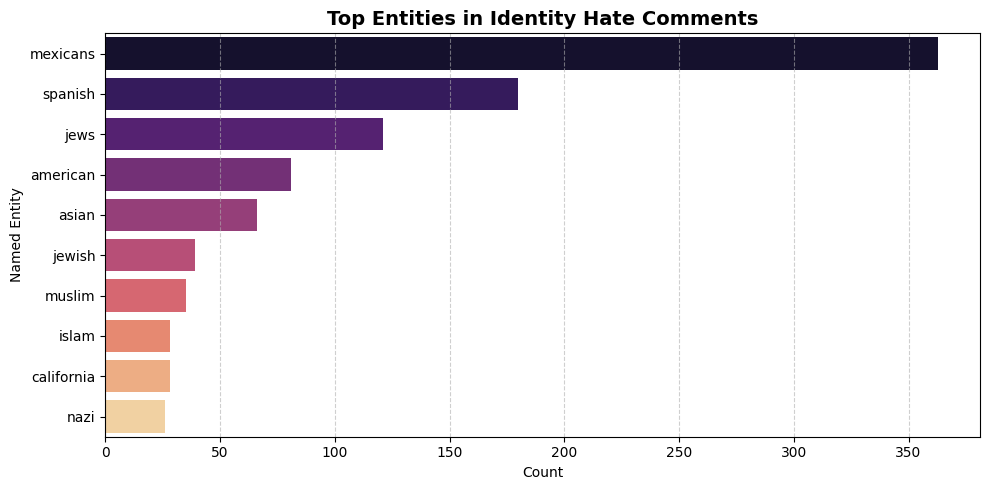

In [32]:
from tqdm import tqdm
tqdm.pandas()

# Filter rows with identity hate present
identity_hate_df = df[df['identity_hate'] == 1].copy()
print(f"Filtered rows with identity hate: {identity_hate_df.shape[0]}")

# Function to extract entities (only relevant types)
def extract_entities(text):
    doc = nlp(text)
    entities = [ent.text for ent in doc.ents if ent.label_ in ["NORP", "ORG", "GPE"]]
    return entities

# Apply NER on the filtered dataset
identity_hate_df["entities"] = identity_hate_df["clean_text"].progress_apply(extract_entities)

# Flatten and count most common entities
all_entities = [ent for ents in identity_hate_df["entities"] for ent in ents]
entity_counts = Counter(all_entities).most_common(10)

# Convert to DataFrame for visualization
entity_df = pd.DataFrame(entity_counts, columns=["Entity", "Count"])

# Visualization
plt.figure(figsize=(10,5))
sns.barplot(data=entity_df, x="Count", y="Entity", palette="magma")
plt.title("Top Entities in Identity Hate Comments", fontsize=14, fontweight="bold")
plt.xlabel("Count")
plt.ylabel("Named Entity")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [33]:
identity_keywords = {'muslim', 'islam', 'jew', 'black', 'white', 'asian', 'christian', 
                     'republican', 'democrat', 'chinese', 'mexican', 
                     'arab', 'usa', 'israel', 'palestine'}

df['identity_entity'] = df['processed_text'].apply(
    lambda x: any(kw in str(x) for kw in identity_keywords)
)



In [34]:

identity_correlation = (df.groupby('identity_entity')['identity_hate'].mean().reset_index())
print(identity_correlation)


   identity_entity  identity_hate
0            False       0.007092
1             True       0.030234


Counting keyword mentions: 100%|██████████| 15/15 [00:00<00:00, 1382.62it/s]


--- Top 5 Targeted Identity Keywords ---
   Keyword  Count  Percentage
1      jew    135         9.6
6    white     54         3.8
10   black     51         3.6
14  muslim     45         3.2
7     arab     30         2.1


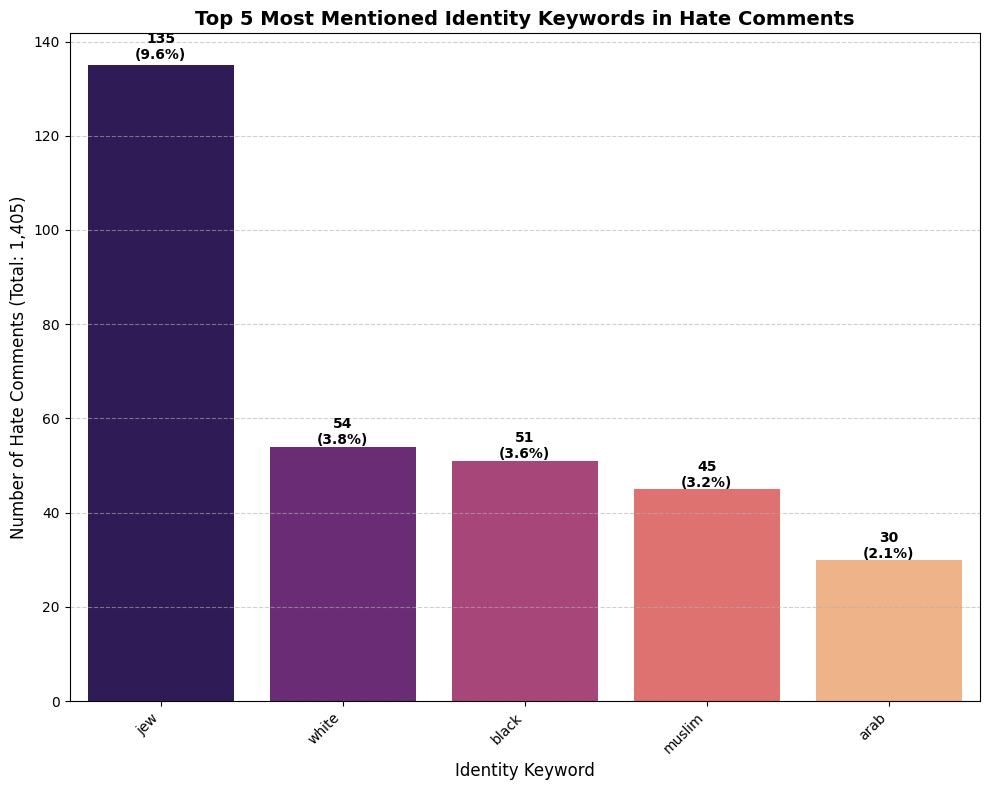

In [35]:

hate_df = df[df['identity_hate'] == 1].copy()

# Total number of hate comments to use in the plot label
total_hate_comments = len(hate_df)

# 2. Count the occurrences of each identity keyword in the hate comments.
keyword_counts = {}

# Using tqdm to track progress during the counting loop
for keyword in tqdm(identity_keywords, desc="Counting keyword mentions"):
    # Count how many texts in the hate subset contain the current keyword
    count = hate_df['processed_text'].apply(
        lambda x: keyword in str(x)
    ).sum()
    keyword_counts[keyword] = count

# 3. Prepare data for visualization
counts_df = pd.DataFrame(
    list(keyword_counts.items()), 
    columns=['Keyword', 'Count']
)
# Calculate the percentage for display
counts_df['Percentage'] = (counts_df['Count'] / total_hate_comments) * 100

# Get the top 5 keywords, sorted by count
top_5_keywords = counts_df.sort_values(by='Count', ascending=False).head(5)

print("\n--- Top 5 Targeted Identity Keywords ---")
print(top_5_keywords[['Keyword', 'Count', 'Percentage']].round(1))

# 4. Visualization
plt.figure(figsize=(10, 8))
sns.barplot(
    data=top_5_keywords,
    x='Keyword',
    y='Count',
    palette='magma' # Use a distinct color palette
)

# Add labels and styling
plt.title("Top 5 Most Mentioned Identity Keywords in Hate Comments", fontsize=14, fontweight='bold')
plt.xlabel("Identity Keyword", fontsize=12)
plt.ylabel(f"Number of Hate Comments (Total: {total_hate_comments:,})", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add values/percentages on bars
for index, row in top_5_keywords.reset_index(drop=True).iterrows():
    # Show count and percentage
    text_label = f"{row['Count']:,}\n({row['Percentage']:.1f}%)"
    # Note: Added 5 to the height for better visibility above the bar
    plt.text(index, row['Count'] * 1.01, text_label, 
             ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

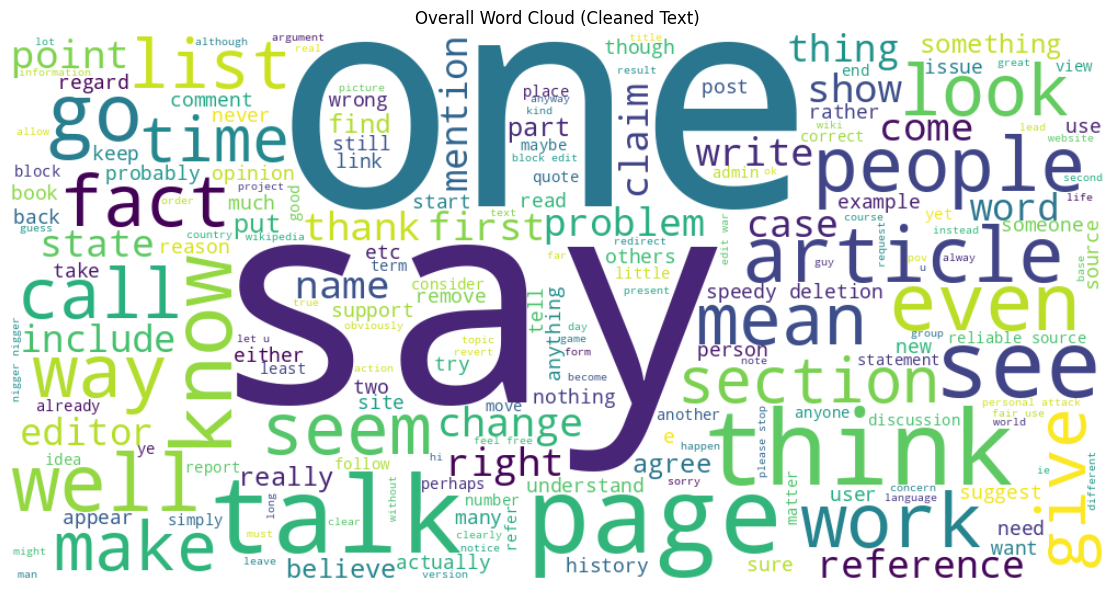

In [36]:
text_all = " ".join(df['processed_text'].dropna())

wordcloud = WordCloud(
    width=1000,
    height=500,
    background_color='white',
    max_words=200,
).generate(text_all)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Overall Word Cloud (Cleaned Text)")
plt.tight_layout()
plt.show()

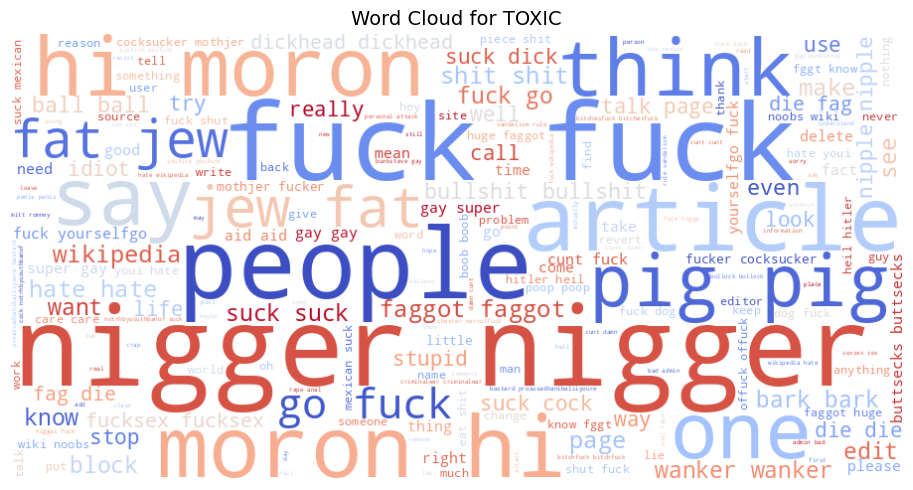

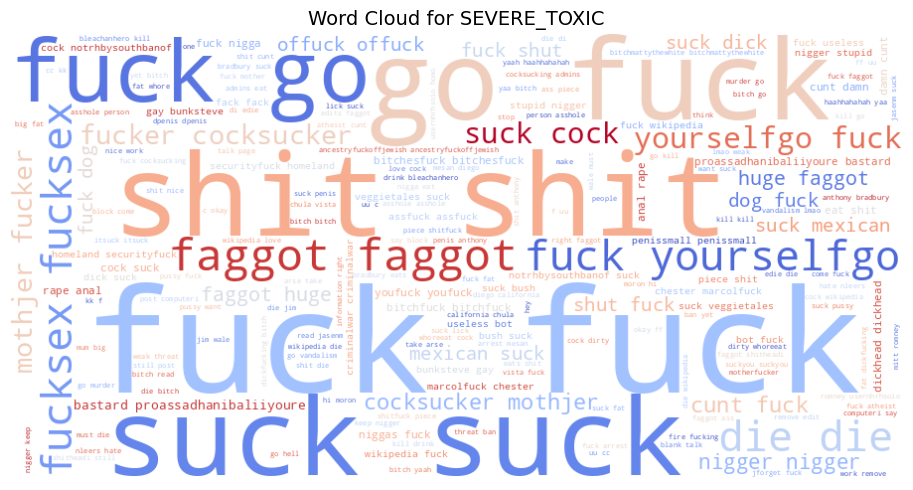

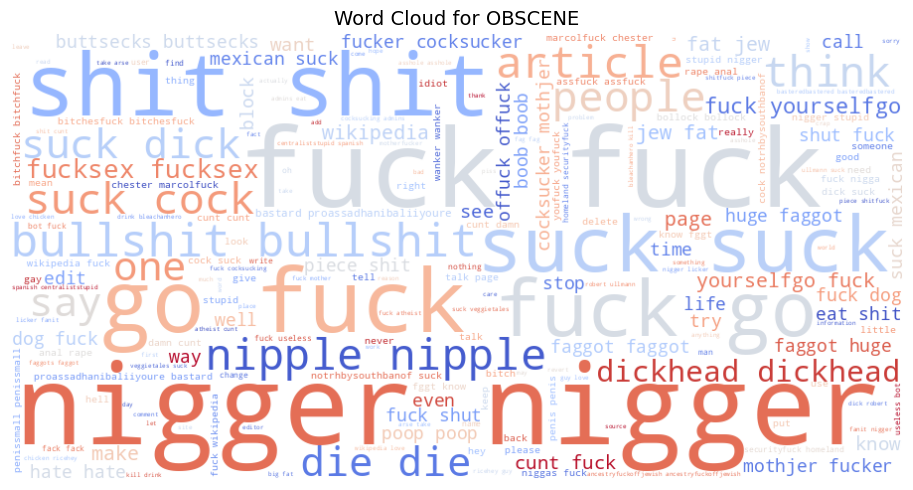

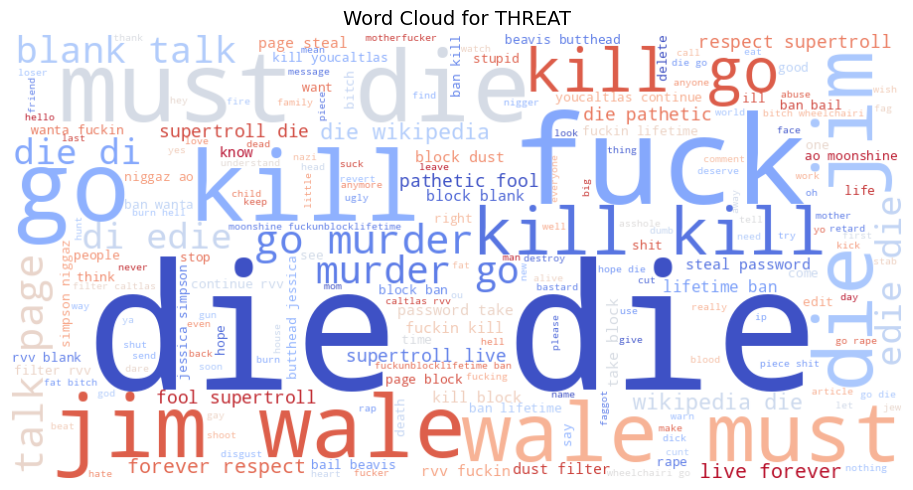

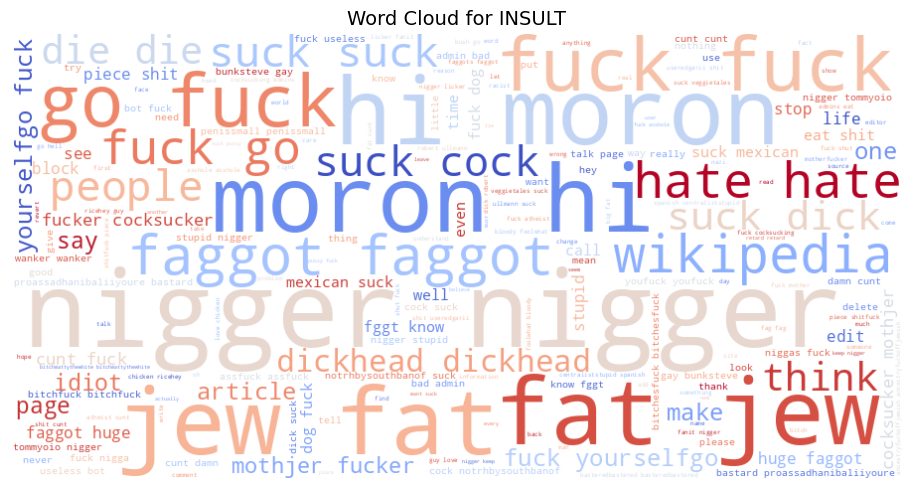

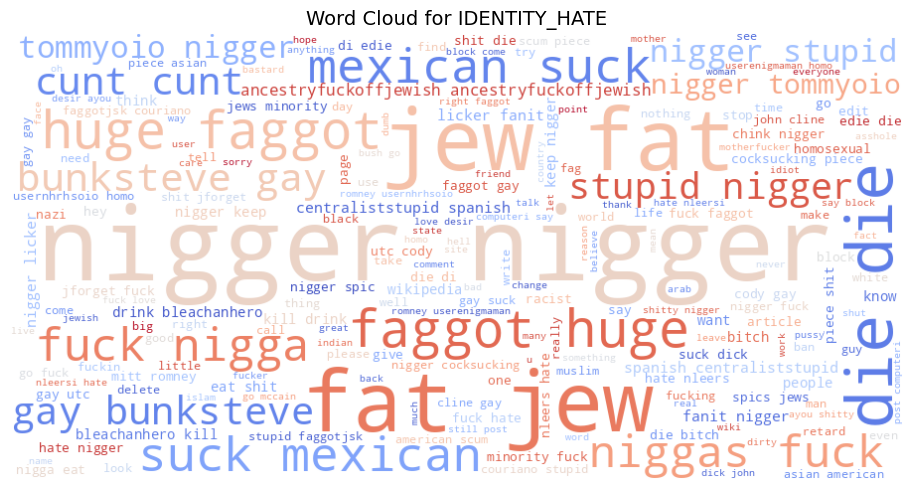

In [37]:
# label_cols = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

for label in label_cols:
    text = " ".join(df[df[label]==1]['processed_text'].dropna())
    wc = WordCloud(width=900, height=450, background_color='white', max_words=200, colormap='coolwarm').generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {label.upper()}", fontsize=14)
    plt.tight_layout()
    plt.show()


In [38]:

df['any_toxic'] = (df[label_cols].sum(axis=1) > 0).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    df['processed_text'],
    df[label_cols],
    test_size=0.2,
    random_state=1,
    stratify=df['any_toxic']
)

In [39]:
print("Distribution of any_toxic:")
print(df['any_toxic'].value_counts(normalize=True))

print("\nDistribution of 'toxic' only:")
print(df['toxic'].value_counts(normalize=True))

print("\nTrain set distribution:")
print(y_train.sum(axis=1).apply(lambda x: x > 0).value_counts(normalize=True))
print("\nTest set distribution:")
print(y_test.sum(axis=1).apply(lambda x: x > 0).value_counts(normalize=True))

Distribution of any_toxic:
any_toxic
0    0.898321
1    0.101679
Name: proportion, dtype: float64

Distribution of 'toxic' only:
toxic
0    0.904156
1    0.095844
Name: proportion, dtype: float64

Train set distribution:
False    0.89832
True     0.10168
Name: proportion, dtype: float64

Test set distribution:
False    0.898324
True     0.101676
Name: proportion, dtype: float64


In [40]:
from sklearn.feature_extraction.text import CountVectorizer

corpus = X_train.astype(str).tolist()

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)

# Vocabulary size
vocab_size = len(vectorizer.vocabulary_)
print(f"Vocabulary size: {vocab_size}")

# Total tokens
total_tokens = X.sum()
print(f"Total tokens: {total_tokens}")


Vocabulary size: 187964
Total tokens: 4298755


In [41]:

tfidf = TfidfVectorizer(
    max_features=20000,        # Top 20k features - balance between coverage and dimensionality
    ngram_range=(1, 3),        # Unigrams + trigrams - captures phrases
    min_df=3,                  # Must appear in at least 3 documents
    max_df=0.9,                # Ignore terms in >90% of documents
    sublinear_tf=True,         # Use log scaling for term frequency
    strip_accents='unicode',   # Remove accents
    dtype=np.float32           # Memory optimization
)


In [42]:

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [43]:

print(f"\nTF-IDF Matrix Shape: {X_train_tfidf.shape}")
print(f"Vocabulary size: {len(tfidf.vocabulary_)}")
print(f"Sparsity: {(1 - X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1])) * 100:.2f}%")



TF-IDF Matrix Shape: (127656, 20000)
Vocabulary size: 20000
Sparsity: 99.85%


In [44]:
base_estimator = LogisticRegression(
    max_iter=5000,             # We have set it higher for convergence
    solver='saga',             # It is best for large datasets and supports L1/L2
    penalty='l2',              # Ridge regularization
    C=1.0,                     # Regularization strength
    class_weight='balanced',   #To handle imbalance
    random_state=1,
    n_jobs=1,                  
    verbose=0
)

In [45]:
clf_ovr = OneVsRestClassifier(base_estimator, n_jobs=-1)  # Parallel training

clf_ovr.fit(X_train_tfidf, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


OneVsRestClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                 max_iter=5000, n_jobs=1,
                                                 random_state=1,
                                                 solver='saga'),
                    n_jobs=-1)

In [46]:
import pickle

# Define file names
MODEL_FILENAME = 'clf_ovr_model.pkl'
VECTORIZER_FILENAME = 'tfidf_vectorizer.pkl'

# --- 1. SAVE THE CLASSIFIER (clf_ovr) ---
with open(MODEL_FILENAME, 'wb') as file:
    # 'wb' means write binary
    pickle.dump(clf_ovr, file)
print(f"✅ Trained classifier saved as: {MODEL_FILENAME}")

# --- 2. SAVE THE TF-IDF VECTORIZER ---
# The vectorizer must be saved too, as it contains the vocabulary and IDF weights
with open(VECTORIZER_FILENAME, 'wb') as file:
    pickle.dump(tfidf, file)
print(f"✅ TF-IDF vectorizer saved as: {VECTORIZER_FILENAME}")

✅ Trained classifier saved as: clf_ovr_model.pkl
✅ TF-IDF vectorizer saved as: tfidf_vectorizer.pkl


In [47]:

y_pred_proba = clf_ovr.predict_proba(X_test_tfidf)

y_pred = clf_ovr.predict(X_test_tfidf)

In [48]:
roc_scores = {}
for i, label in enumerate(label_cols):
    y_prob = y_pred_proba[:, i]  
    roc_auc = roc_auc_score(y_test.iloc[:, i], y_prob)
    roc_scores[label] = roc_auc
    print(f"{label:20s} ROC-AUC: {roc_auc:.4f}")

mean_roc_auc = np.mean(list(roc_scores.values()))
print(f"\n{'Mean ROC-AUC':20s} {mean_roc_auc:.4f}")


toxic                ROC-AUC: 0.9697
severe_toxic         ROC-AUC: 0.9755
obscene              ROC-AUC: 0.9798
threat               ROC-AUC: 0.9517
insult               ROC-AUC: 0.9697
identity_hate        ROC-AUC: 0.9574

Mean ROC-AUC         0.9673


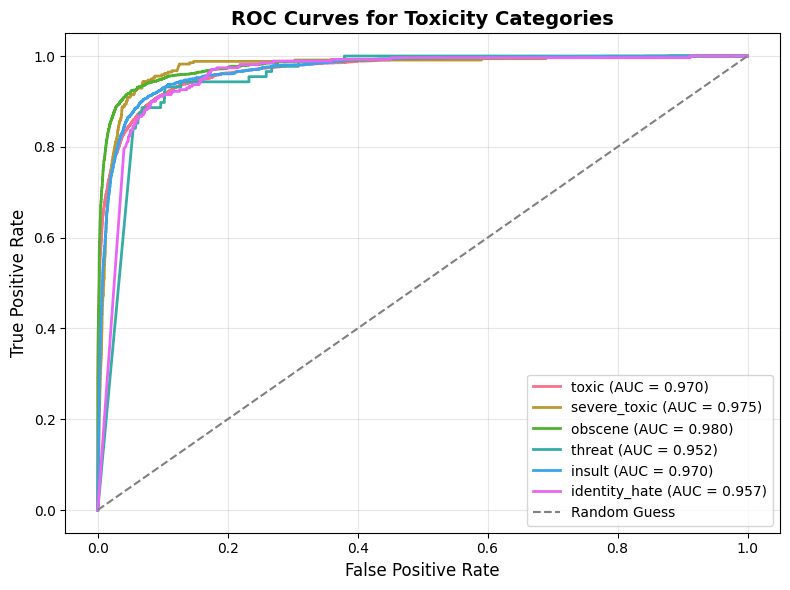

In [49]:
plt.figure(figsize=(8, 6))

# Color palette for distinction
colors = sns.color_palette("husl", len(label_cols))

# Plot ROC curve for each class
for i, label in enumerate(label_cols):
    y_true = y_test.iloc[:, i]
    y_prob = y_pred_proba[:, i]
    
    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color=colors[i], lw=2, 
             label=f"{label} (AUC = {roc_auc:.3f})")

# Plot random guess baseline
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1.5, label='Random Guess')

# Plot styling
plt.title("ROC Curves for Toxicity Categories", fontsize=14, fontweight='bold')
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [50]:

print(f"\nHamming Loss: {hamming_loss(y_test, y_pred):.4f}")



Hamming Loss: 0.0775


In [51]:
for i, label in enumerate(label_cols):
    print(f"\n{label.upper()}:")
    precision, recall, f1, support = precision_recall_fscore_support(
        y_test.iloc[:, i], 
        y_pred[:, i], 
        average='binary',
        zero_division=0
    )
    print(f"  Precision: {precision:.3f}")
    print(f"  Recall:    {recall:.3f}")
    print(f"  F1-Score:  {f1:.3f}")


TOXIC:
  Precision: 0.615
  Recall:    0.862
  F1-Score:  0.718

SEVERE_TOXIC:
  Precision: 0.460
  Recall:    0.253
  F1-Score:  0.326

OBSCENE:
  Precision: 0.898
  Recall:    0.657
  F1-Score:  0.759

THREAT:
  Precision: 0.022
  Recall:    0.932
  F1-Score:  0.044

INSULT:
  Precision: 0.314
  Recall:    0.934
  F1-Score:  0.470

IDENTITY_HATE:
  Precision: 0.050
  Recall:    0.937
  F1-Score:  0.096


In [52]:
"""
Attempting to fix Precision/Recall Imbalance
"""

print("="*70)
print("Precision/Recall Imbalance Issue")
print("="*70)

label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Get probability predictions
y_pred_proba = clf_ovr.predict_proba(X_test_tfidf)

print("\nCurrent Performance @ Threshold = 0.5:")
print("-" * 70)
print(f"{'Label':<20} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Issue'}")
print("-" * 70)

current_metrics = {}

for i, label in enumerate(label_cols):
    y_true = y_test.iloc[:, i]
    y_prob = y_pred_proba[:, i]  # Get positive class probabilities
    y_pred_05 = (y_prob >= 0.5).astype(int)
    
    prec = precision_score(y_true, y_pred_05, zero_division=0)
    rec = recall_score(y_true, y_pred_05, zero_division=0)
    f1 = f1_score(y_true, y_pred_05, zero_division=0)
    
    current_metrics[label] = {'precision': prec, 'recall': rec, 'f1': f1}
    
    # Diagnose issue
    if prec < 0.5 and rec > 0.7:
        issue = "TOO AGGRESSIVE (over-predicting)"
    elif prec > 0.5 and rec < 0.3:
        issue = "TOO CONSERVATIVE (under-predicting)"
    else:
        issue = "Balanced"
    
    print(f"{label:<20} {prec:<12.3f} {rec:<12.3f} {f1:<12.3f} {issue}")

print("\n💡 KEY INSIGHT:")
print("   Most labels: High Recall, Low Precision → Predicting too many as toxic")
print("   Identity_hate: Low Recall, High Precision → Predicting too few as toxic")
print("   Solution: Find optimal threshold for EACH label separately")

print("\n" + "="*70)
print("FINDING OPTIMAL THRESHOLDS")
print("="*70)

optimal_thresholds = {}
optimization_results = {}


for i, label in enumerate(label_cols):
    y_true = y_test.iloc[:, i]
    y_prob = y_pred_proba[:, i]
    
    # Calculate precision-recall curve
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_prob)
    
    # Strategy 1: Maximize F1-Score
    f1_scores = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1] + 1e-10)
    best_f1_idx = np.argmax(f1_scores)
    f1_optimal_threshold = thresholds[best_f1_idx]
    f1_optimal_score = f1_scores[best_f1_idx]
    
    # Strategy 2: Balance precision and recall (closest to diagonal)
    pr_diff = np.abs(precisions[:-1] - recalls[:-1])
    balanced_idx = np.argmin(pr_diff)
    balanced_threshold = thresholds[balanced_idx]
    balanced_f1 = f1_scores[balanced_idx]
    
    # Strategy 3: Minimum precision constraint (e.g., precision >= 0.7)
    min_precision = 0.7
    valid_indices = np.where(precisions[:-1] >= min_precision)[0]
    if len(valid_indices) > 0:
        constrained_idx = valid_indices[np.argmax(f1_scores[valid_indices])]
        constrained_threshold = thresholds[constrained_idx]
        constrained_f1 = f1_scores[constrained_idx]
    else:
        constrained_threshold = f1_optimal_threshold
        constrained_f1 = f1_optimal_score
    
    # Choose F1-optimal as default
    optimal_thresholds[label] = f1_optimal_threshold
    
    optimization_results[label] = {
        'f1_optimal': (f1_optimal_threshold, f1_optimal_score),
        'balanced': (balanced_threshold, balanced_f1),
        'constrained': (constrained_threshold, constrained_f1),
        'precision_at_optimal': precisions[best_f1_idx],
        'recall_at_optimal': recalls[best_f1_idx]
    }
    
    # Print results
    print(f"\n{label.upper()}:")
    print(f"  Class distribution: {y_true.mean()*100:.2f}% positive")
    print(f"  Current (threshold=0.5):")
    print(f"    Precision: {current_metrics[label]['precision']:.3f}")
    print(f"    Recall:    {current_metrics[label]['recall']:.3f}")
    print(f"    F1-Score:  {current_metrics[label]['f1']:.3f}")
    print(f"  Optimal (threshold={f1_optimal_threshold:.3f}):")
    print(f"    Precision: {precisions[best_f1_idx]:.3f}")
    print(f"    Recall:    {recalls[best_f1_idx]:.3f}")
    print(f"    F1-Score:  {f1_optimal_score:.3f}")
    print(f"  Improvement: {f1_optimal_score - current_metrics[label]['f1']:+.3f}")
    
    

print("\n" + "="*70)
print("APPLYING OPTIMAL THRESHOLDS")
print("="*70)

# Ensure y_pred_proba is in shape (n_samples, n_labels).
# If predict_proba returned a list of arrays, convert to array.
# (This is robust to both list-of-arrays and numpy-array outputs.)
if isinstance(y_pred_proba, list):
    # list of arrays of shape (n_samples,) -> stack into (n_samples, n_labels)
    y_pred_proba = np.vstack(y_pred_proba).T  # <<< CHANGED: make into shape (n_samples, n_labels)

# Now y_pred_proba should be a 2D array: (n_samples, n_labels)
n_samples = X_test_tfidf.shape[0]             # <<< CHANGED: use shape[0] for sparse matrices
n_labels = len(label_cols)

# Create new predictions with optimal thresholds
y_pred_optimized = np.zeros((n_samples, n_labels), dtype=int)  # <<< CHANGED: use n_samples variable

for i, label in enumerate(label_cols):
    threshold = optimal_thresholds[label]
    # y_prob is column i (probability of positive class for label i)
    y_prob = y_pred_proba[:, i]  # already 1D array of length n_samples
    y_pred_optimized[:, i] = (y_prob >= threshold).astype(int)

print("\nOptimal thresholds found:")
for label, threshold in optimal_thresholds.items():
    print(f"  {label:<20} {threshold:.4f}")



comparison_data = []

# Ensure you have y_pred (default 0.5 predictions) defined;
# if not available, compute it now from y_pred_proba using 0.5 threshold
# (This is the "Before" predictions used in your earlier comparisons.)
if 'y_pred' not in globals():
    y_pred = (y_pred_proba >= 0.5).astype(int)   # shape: (n_samples, n_labels)

for i, label in enumerate(label_cols):
    y_true = y_test.iloc[:, i].values
    y_pred_default = y_pred[:, i]
    y_pred_opt = y_pred_optimized[:, i]

    # Before
    prec_before = precision_score(y_true, y_pred_default, zero_division=0)
    rec_before = recall_score(y_true, y_pred_default, zero_division=0)
    f1_before = f1_score(y_true, y_pred_default, zero_division=0)

    # After
    prec_after = precision_score(y_true, y_pred_opt, zero_division=0)
    rec_after = recall_score(y_true, y_pred_opt, zero_division=0)
    f1_after = f1_score(y_true, y_pred_opt, zero_division=0)

    comparison_data.append({
        'Label': label,
        'Threshold': optimal_thresholds[label],
        'Precision_Before': prec_before,
        'Precision_After': prec_after,
        'Recall_Before': rec_before,
        'Recall_After': rec_after,
        'F1_Before': f1_before,
        'F1_After': f1_after,
        'F1_Improvement': f1_after - f1_before
    })

    print(f"\n{label.upper()} (threshold: {optimal_thresholds[label]:.3f}):")
    print(f"  {'Metric':<12} {'Before':<10} {'After':<10} {'Change':<10}")
    print(f"  {'-'*45}")
    print(f"  {'Precision':<12} {prec_before:<10.3f} {prec_after:<10.3f} {prec_after-prec_before:+10.3f}")
    print(f"  {'Recall':<12} {rec_before:<10.3f} {rec_after:<10.3f} {rec_after-rec_before:+10.3f}")
    print(f"  {'F1-Score':<12} {f1_before:<10.3f} {f1_after:<10.3f} {f1_after-f1_before:+10.3f}")

comparison_df = pd.DataFrame(comparison_data)

# Overall summary
avg_f1_before = comparison_df['F1_Before'].mean()
avg_f1_after = comparison_df['F1_After'].mean()
avg_improvement = comparison_df['F1_Improvement'].mean()

print("\n" + "="*70)
print("OVERALL SUMMARY")
print("="*70)


import pickle

# Save optimal thresholds
with open('optimal_thresholds.pkl', 'wb') as f:
    pickle.dump(optimal_thresholds, f)

print("\nOptimal thresholds saved to 'optimal_thresholds.pkl'")



Precision/Recall Imbalance Issue

Current Performance @ Threshold = 0.5:
----------------------------------------------------------------------
Label                Precision    Recall       F1-Score     Issue
----------------------------------------------------------------------
toxic                0.615        0.862        0.718        Balanced
severe_toxic         0.460        0.253        0.326        Balanced
obscene              0.898        0.657        0.759        Balanced
threat               0.022        0.932        0.044        TOO AGGRESSIVE (over-predicting)
insult               0.314        0.934        0.470        TOO AGGRESSIVE (over-predicting)
identity_hate        0.050        0.937        0.096        TOO AGGRESSIVE (over-predicting)

💡 KEY INSIGHT:
   Most labels: High Recall, Low Precision → Predicting too many as toxic
   Identity_hate: Low Recall, High Precision → Predicting too few as toxic
   Solution: Find optimal threshold for EACH label separately

FINDI

In [53]:
from scipy.sparse import issparse # Import the necessary function

feature_names = tfidf.get_feature_names_out()

for i, label in enumerate(label_cols):
    
    # Get the coefficient object for the current class
    coef_obj = clf_ovr.estimators_[i].coef_
    
    # 🌟 CORRECTED LOGIC: Convert to dense array only if it's sparse
    if issparse(coef_obj):
        coef = coef_obj.toarray().flatten()
    else:
        # If it's already a dense NumPy array, just flatten it
        coef = coef_obj.flatten() 
    
    # The rest of your logic remains correct
    top_pos = np.argsort(coef)[-15:]  # Top toxic words
    top_neg = np.argsort(coef)[:15]   # Words that reduce toxicity
    
    print(f"\nTop +ve words for '{label}':")
    print(", ".join(feature_names[top_pos]))
    
    print(f"Top -ve words for '{label}':")
    print(", ".join(feature_names[top_neg]))


Top +ve words for 'toxic':
pathetic, faggot, fucking, dick, moron, bitch, crap, asshole, as, bullshit, suck, shit, idiot, stupid, fuck
Top -ve words for 'toxic':
thank, redirect, thanks, cheer, section, please, talk, appreciate, article, mention, science, process, source, dispute, consensus

Top +ve words for 'severe_toxic':
motherfucker, asshole, prick, fuck tell, faggot, die, cock, as, fucking, fag, penis, fucker, bitch, shit, fuck
Top -ve words for 'severe_toxic':
article, well, talk, look, see, remove, call, add, please, write, still, new, edit, fact, page

Top +ve words for 'obscene':
penis, dick, bastard, stupid, motherfucker, idiot, fucking, asshole, cunt, bitch, as, bullshit, suck, shit, fuck
Top -ve words for 'obscene':
article, please, agree, suggest, base, sure, look, need, many, men, sense, seem, official, check, figure

Top +ve words for 'threat':
physician, live, whoever, burn hell, sitush, house, mother, fuck, fee, burn, face, as, kill, death, die
Top -ve words for 'thr

In [54]:
!pip install shap --quiet

import shap
# df['processed_text'].iloc[55]

In [55]:
df['processed_text'].iloc[55]

'stupid peace shit stop deleting stuff asshole go die fall hole go hell'

In [56]:

label_index = 0  # 0 for 'toxic', 1 for 'severe_toxic', etc.
label_name = label_cols[label_index]

background_sample = df['processed_text'].sample(200, random_state=42).tolist()

explainer = shap.LinearExplainer(
    clf_ovr.estimators_[label_index],
    tfidf.transform(background_sample),
    feature_names=tfidf.get_feature_names_out()
)

sample_text = [df['processed_text'].iloc[55]]

# Get SHAP values
shap_values = explainer.shap_values(tfidf.transform(sample_text))

shap.initjs()
shap.force_plot(
    explainer.expected_value, 
    shap_values, 
    feature_names=tfidf.get_feature_names_out()
)


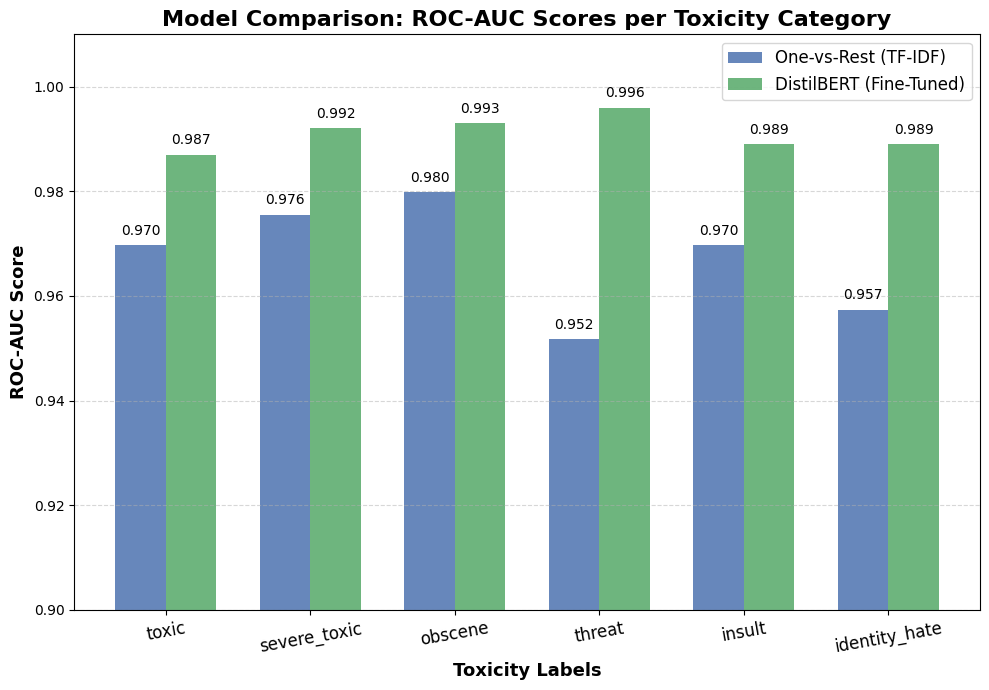

In [4]:
# -----------------------------
# ROC-AUC values
# -----------------------------
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

ovr_auc = [0.9697, 0.9755, 0.9798, 0.9517, 0.9697, 0.9574]
bert_auc = [0.987, 0.992, 0.993, 0.996, 0.989, 0.989]

x = np.arange(len(labels))
width = 0.35

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(10, 7))

bar1 = plt.bar(x - width/2, ovr_auc, width, label='One-vs-Rest (TF-IDF)', color='#4C72B0', alpha=0.85)
bar2 = plt.bar(x + width/2, bert_auc, width, label='DistilBERT (Fine-Tuned)', color='#55A868', alpha=0.85)

# -----------------------------
# Add labels & titles
# -----------------------------
plt.xlabel("Toxicity Labels", fontsize=13, fontweight='bold')
plt.ylabel("ROC-AUC Score", fontsize=13, fontweight='bold')
plt.title("Model Comparison: ROC-AUC Scores per Toxicity Category", fontsize=16, fontweight='bold')

plt.xticks(x, labels, rotation=10, fontsize=12)
plt.ylim(0.9, 1.01)
plt.legend(fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.5)

# -----------------------------
# Add score annotations
# -----------------------------
for bar in bar1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.002,
             f"{height:.3f}", ha='center', fontsize=10)

for bar in bar2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.002,
             f"{height:.3f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()


In [58]:
# def preprocess_pipeline(df):
#     df['comment_text'] = df['comment_text'].apply(clean_text)
#     df['comment_text'] = df['comment_text'].apply(tokenize_text)
#     df['comment_text'] = df['comment_text'].apply(remove_stopwords)
#     df['comment_text'] = df['comment_text'].apply(lemmatize_with_pos)
#     df['comment_text'] = df['comment_text'].apply(lambda tokens: " ".join(tokens))
#     return df

In [59]:
# df_test = preprocess_pipeline(df_test)

# final_X_test = tfidf.transform(df_test['comment_text'])

In [60]:

# final_y_test_pred_proba = clf_ovr.predict_proba(final_X_test)
# print(final_y_test_pred_proba)

In [61]:

# submission = pd.DataFrame(final_y_test_pred_proba, columns=label_cols)
# submission.insert(0, 'id', df_test['id'])
# submission.to_csv("jigsaw_submission.csv", index=False)
